# Loss Landscapes on CIFAR

We visualize loss landscapes using [filter normalization](https://arxiv.org/abs/1712.09913) to show that ***self-attentions flatten loss landscapes*** as shown in Fig 1.a and Fig C.4.a.

In [2]:
import sys

# check whether run in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install matplotlib
    !pip3 install einops==0.4.1
    !pip3 install timm==0.5.4
    !pip3 install pandas==1.3.2
    !git clone https://github.com/xxxnell/how-do-vits-work.git
    root = "./how-do-vits-work"
    sys.path.append(root)

In [61]:
import os
import yaml
import copy
from pathlib import Path

import torch
from torch.utils.data import DataLoader

import models
import ops.tests as tests
import ops.datasets as datasets
import ops.loss_landscapes as lls

usage: ipykernel_launcher.py [-h] [--is_ab IS_AB] [--w_loss_vgg7 W_LOSS_VGG7]
                             [--w_loss_CharbonnierLoss W_LOSS_CHARBONNIERLOSS]
                             [--batch_size BATCH_SIZE] [--nepoch NEPOCH]
                             [--train_workers TRAIN_WORKERS]
                             [--eval_workers EVAL_WORKERS] [--dataset DATASET]
                             [--pretrain_weights PRETRAIN_WEIGHTS]
                             [--optimizer OPTIMIZER] [--lr_initial LR_INITIAL]
                             [--weight_decay WEIGHT_DECAY] [--gpu GPU]
                             [--arch ARCH] [--mode MODE] [--save_dir SAVE_DIR]
                             [--save_images] [--env ENV]
                             [--checkpoint CHECKPOINT]
                             [--norm_layer NORM_LAYER] [--embed_dim EMBED_DIM]
                             [--win_size WIN_SIZE]
                             [--token_projection TOKEN_PROJECTION]
                         

SystemExit: 2

C:\Users\pc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [62]:
# config_path = "%s/configs/cifar10_vit.yaml" % root
config_path = "%s/configs/cifar100_vit.yaml" % root
# config_path = "%s/configs/imagenet_vit.yaml" % root

# 获取一些参数
with open(config_path) as f:
    args = yaml.load(f)
    print(args)

{'dataset': {'name': 'cifar100', 'root': '../data', 'mean': [0.5071, 0.4867, 0.4408], 'std': [0.2675, 0.2565, 0.2761], 'padding': 4, 'color_jitter': 0.0, 'auto_augment': 'rand-m9-n2-mstd1.0', 're_prob': 0.0}, 'train': {'warmup_epochs': 5, 'epochs': 300, 'batch_size': 96, 'max_norm': 5, 'smoothing': 0.1, 'mixup': {'num_classes': 100, 'mixup_alpha': 1.0, 'cutmix_alpha': 0.8, 'prob': 1.0}}, 'val': {'batch_size': 256, 'n_ff': 1}, 'model': {'stem': False, 'block': {'image_size': 32, 'patch_size': 2, 'sd': 0.1}}, 'optim': {'name': 'AdamW', 'lr': 0.000125, 'weight_decay': 0.05, 'scheduler': {'name': 'CosineAnnealingLR', 'T_max': 300, 'eta_min': 0}}, 'env': {}}


In [63]:
dataset_args = copy.deepcopy(args).get("dataset")
train_args = copy.deepcopy(args).get("train")
val_args = copy.deepcopy(args).get("val")
model_args = copy.deepcopy(args).get("model")
optim_args = copy.deepcopy(args).get("optim")
env_args = copy.deepcopy(args).get("env")

In [5]:
import torch.nn as nn
# 加载数据，再让数据转化
dataset_train, dataset_test = datasets.get_dataset(**dataset_args, download=True)
dataset_name = dataset_args["name"]
num_classes = len(dataset_train.classes)  # torchvision.datasets.CIFAR10中的一个值

# 这一步就是按照batch加载数据，和去雾同
dataset_train = DataLoader(dataset_train, 
                           shuffle=True, 
                           num_workers=train_args.get("num_workers", 4), 
                           batch_size=train_args.get("batch_size", 128))
dataset_test = DataLoader(dataset_test, 
                          num_workers=val_args.get("num_workers", 4), 
                          batch_size=val_args.get("batch_size", 128))

print("Train: %s, Test: %s, Classes: %s" % (
    len(dataset_train.dataset), 
    len(dataset_test.dataset), 
    num_classes
))

169001984it [16:58, 165964.64it/s]                                                                                     


Extracting ../data\cifar-100-python.tar.gz to ../data
Files already downloaded and verified
Train: 50000, Test: 10000, Classes: 100


In [7]:
from timm.data import Mixup

def mixup_function(train_args):
    train_args = copy.deepcopy(train_args)
    smoothing = train_args.get("smoothing", 0.0)
    mixup_args = train_args.get("mixup", None)

    mixup_function = Mixup(
        **mixup_args,
        label_smoothing=smoothing,
    ) if mixup_args is not None else None
    return mixup_function


transform = mixup_function(train_args)

## Load Pretrained Models

The cells below provide the snippets for ResNet-50 and ViT-Ti:

In [ ]:
# download and load a pretrained model for CIFAR-100
url = "https://github.com/xxxnell/how-do-vits-work-storage/releases/download/v0.1/resnet_50_cifar100_691cc9a9e4.pth.tar"
path = "checkpoints/resnet_50_cifar100_691cc9a9e4.pth.tar"
models.download(url=url, path=path)

name = "resnet_50"
uid = "691cc9a9e4"
model = models.get_model(name, num_classes=num_classes,  # timm does not provide a ResNet for CIFAR
                         stem=model_args.get("stem", False))  # false
map_location = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(path, map_location=map_location)
model.load_state_dict(checkpoint["state_dict"])

In [8]:
import copy
import timm
import torch
import torch.nn as nn

# download and load a pretrained model for CIFAR-100
url = "https://github.com/xxxnell/how-do-vits-work-storage/releases/download/v0.1/vit_ti_cifar100_9857b21357.pth.tar"
path = "checkpoints/vit_ti_cifar100_9857b21357.pth.tar"
models.download(url=url, path=path)

model = timm.models.vision_transformer.VisionTransformer(
    num_classes=num_classes, img_size=32, patch_size=2,  # for CIFAR
    embed_dim=192, depth=12, num_heads=3, qkv_bias=False,  # for ViT-Ti 
)
model.name = "vit_ti"
uid = "9857b21357"
models.stats(model)
map_location = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(path, map_location=map_location)
model.load_state_dict(checkpoint["state_dict"])

100%|████████████████████████████████████████████████████████████████████████████| 65.0M/65.0M [00:19<00:00, 3.38MiB/s]


model: vit_ti , params: 5.4M


<All keys matched successfully>

## Investigate the Loss Landscape

We measure not only NLL but also "L2" on "augmented training datasets".

In [ ]:
scale = 1e-0
n = 21
gpu = torch.cuda.is_available()

# transform = mixup_function(train_args) MixUp
# dataset_train：经过各种transforms转化后的训练数据

### metrics_grid[tuple(ratio)] = (l1, l2, *metrics) ###
metrics_grid = lls.get_loss_landscape(
    model, 1, dataset_train, transform=transform,
    kws=["pos_embed", "relative_position"],
    x_min=-1.0 * scale, x_max=1.0 * scale, n_x=n, y_min=-1.0 * scale, y_max=1.0 * scale, n_y=n, gpu=gpu,
)
leaderboard_path = os.path.join("leaderboard", "logs", dataset_name, model.name)
Path(leaderboard_path).mkdir(parents=True, exist_ok=True)

metrics_dir = os.path.join(leaderboard_path, "%s_%s_%s_x%s_losslandscape.csv" % (dataset_name, model.name, uid, int(1 / scale)))
"""
metrics_grid = {tuple(ratio):(l1, l2, *metrics)}  {[-1. -1.]: (l1, l2, *metrics)}
               [[*grid, *metrics] for grid, metrics in metrics_grid.items()]
               其中metrics = nll_value, \
                             cutoffs, cms, accs, uncs, ious, freqs, \
                             topk_value, brier_value, \
                             count_bin, acc_bin, conf_bin, ece_value, ecse_value
"""
metrics_list = [[*grid, *metrics] for grid, metrics in metrics_grid.items()]
tests.save_metrics(metrics_dir, metrics_list)

Grid:  [-1. -1.], NLL: 5.3453, Cutoffs: 0.0 %, 90.0 %, Accs: 0.962 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 0.122 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 4.758 %, Brier: 1.020, ECE: 11.217 %, ECE±: 11.217 %
Grid:  [-0.9 -1. ], NLL: 5.3610, Cutoffs: 0.0 %, 90.0 %, Accs: 0.854 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 0.107 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 4.820 %, Brier: 1.025, ECE: 12.814 %, ECE±: 12.814 %
Grid:  [-0.8 -1. ], NLL: 5.3660, Cutoffs: 0.0 %, 90.0 %, Accs: 0.852 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 0.081 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 4.962 %, Brier: 1.029, ECE: 14.056 %, ECE±: 14.056 %
Grid:  [-0.7 -1. ], NLL: 5.3488, Cutoffs: 0.0 %, 90.0 %, Accs: 0.776 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 0.055 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 5.054 %, Brier: 1.030, ECE: 14.867 %, ECE±: 14.867 %
Grid:  [-0.6 -1. ], NLL: 5.3135, Cutoffs: 0.0 %, 90.0 %, Accs: 0.812 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 0.077 %, 0.000 %,

## Plot the Loss Landscape

For the given loss landscape raw data, we visualize the loss (NLL + L2) landscape.

[21, 21]


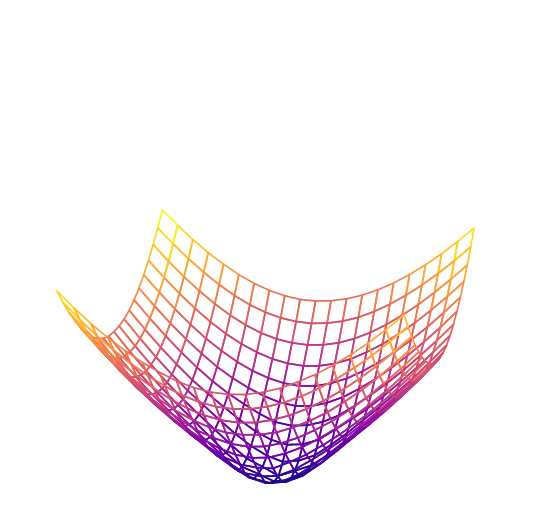

In [16]:
%matplotlib inline 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


root = 'C:/Users/pc/Desktop/how-do-vits-work-transformer'
# load losslandscape raw data of ResNet-50 or ViT-Ti
names = ["x", "y", "l1", "l2", "NLL", "Cutoff1", "Cutoff2", "Acc", "Acc-90", "Unc", "Unc-90", "IoU", "IoU-90", "Freq", "Freq-90", "Top-5", "Brier", "ECE", "ECSE"]
# path = "%s/resources/results/cifar100_resnet_dnn_50_losslandscape.csv" % root  # for ResNet-50
path = "%s/resources/results/cifar100_vit_ti_losslandscape.csv" % root  # for ViT-Ti
data = pd.read_csv(path, names=names)
data["loss"] = data["NLL"] + optim_args["weight_decay"] * data["l2"]  # NLL + weight_decay * l2

# prepare data
p = int(math.sqrt(len(data)))
shape = [p, p]
print(shape)

xs = np.array(data["x"]).reshape(shape) 
ys = np.array(data["y"]).reshape(shape)
zs = np.array(data["loss"]).reshape(shape)
# xs = data["x"].to_numpy().reshape(shape) 
# ys = data["y"].to_numpy().reshape(shape)
# zs = data["loss"].to_numpy().reshape(shape)

zs = zs - zs[np.isfinite(zs)].min()
zs[zs > 42] = np.nan

# Normalize(vmin=None, vmax=None) 是用来把数据标准化(归一化)到[0,1]这个期间内,
# vmin是设置最小值, vmax是设置最大值，小于最小值就取最小值，大于最大值就取最大值。
norm = plt.Normalize(zs[np.isfinite(zs)].min(), zs[np.isfinite(zs)].max())  # normalize to [0,1]
colors = cm.plasma(norm(zs))
rcount, ccount, _ = colors.shape

fig = plt.figure(figsize=(4.2, 4), dpi=120)
ax = fig.gca(projection="3d")
ax.view_init(elev=15, azim=15)  # angle

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

surf = ax.plot_surface(
    xs, ys, zs, 
    rcount=rcount, ccount=ccount,
    facecolors=colors, shade=False,
)
surf.set_facecolor((0,0,0,0))

# remove white spaces
adjust_lim = 0.8
ax.set_xlim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_ylim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_zlim(10, 32)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')

plt.show()

0      61.217708
1      59.848638
2      58.574297
3      57.405712
4      56.362975
         ...    
436    56.271707
437    57.292727
438    58.442064
439    59.689191
440    61.036105
Name: loss, Length: 441, dtype: float64
[21, 21]


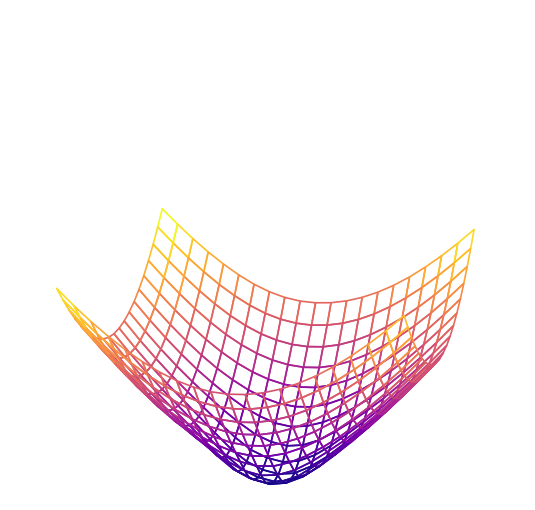

In [65]:
%matplotlib inline 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


root = 'C:/Users/pc/Desktop/how-do-vits-work-transformer'
# load losslandscape raw data of ResNet-50 or ViT-Ti
names = ["x", "y", "l1", "l2", "NLL", "Cutoff1", "Cutoff2", "Acc", "Acc-90", "Unc", "Unc-90", "IoU", "IoU-90", "Freq", "Freq-90", "Top-5", "Brier", "ECE", "ECSE"]
# path = "%s/resources/results/cifar100_resnet_dnn_50_losslandscape.csv" % root  # for ResNet-50
path = "%s/resources/results/cifar100_vit_ti_9857b21357_x1_losslandscape.csv" % root  # for ViT-Ti
data = pd.read_csv(path, names=names)
data["loss"] = data["NLL"] + optim_args["weight_decay"] * data["l2"]  # NLL + weight_decay * l2
print(data["loss"])
# prepare data
p = int(math.sqrt(len(data)))
shape = [p, p]
print(shape)

xs = np.array(data["x"]).reshape(shape) 
ys = np.array(data["y"]).reshape(shape)
zs = np.array(data["loss"]).reshape(shape)
# xs = data["x"].to_numpy().reshape(shape) 
# ys = data["y"].to_numpy().reshape(shape)
# zs = data["loss"].to_numpy().reshape(shape)

zs = zs - zs[np.isfinite(zs)].min()
zs[zs > 42] = np.nan

# Normalize(vmin=None, vmax=None) 是用来把数据标准化(归一化)到[0,1]这个期间内,
# vmin是设置最小值, vmax是设置最大值，小于最小值就取最小值，大于最大值就取最大值。
norm = plt.Normalize(zs[np.isfinite(zs)].min(), zs[np.isfinite(zs)].max())  # normalize to [0,1]
colors = cm.plasma(norm(zs))
rcount, ccount, _ = colors.shape

fig = plt.figure(figsize=(4.2, 4), dpi=120)
ax = fig.gca(projection="3d")
ax.view_init(elev=15, azim=15)  # angle

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

surf = ax.plot_surface(
    xs, ys, zs, 
    rcount=rcount, ccount=ccount,
    facecolors=colors, shade=False,
)
surf.set_facecolor((0,0,0,0))

# remove white spaces
adjust_lim = 0.8
ax.set_xlim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_ylim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_zlim(10, 32)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')

plt.show()

441
[21, 21]


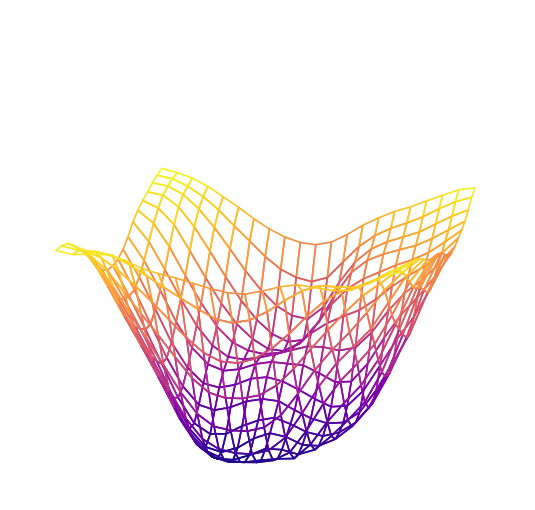

In [2]:
%matplotlib inline 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

############### Plot the Loss Landscape ###############
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# load losslandscape raw data of ResNet-50 or ViT-Ti
names = ["x", "y", "l1", "l2", "loss_value"]
# path = "%s/resources/results/cifar100_resnet_dnn_50_losslandscape.csv" % root  # for ResNet-50
path = r'C:\Users\pc\Desktop\how-do-vits-work-transformer\checkpoints\logs\NH\Uformer_Informer\NH_Uformer_Informer_x1_losslandscape.csv'
data = pd.read_csv(path, names=names)
data["loss"] = data["loss_value"]

path = r'C:\Users\pc\Desktop\how-do-vits-work-transformer\checkpoints\logs\NH\Uformer_Informer\middle_result.txt'
x, y = [], []
with open(path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    data_x, data_y, loss = [], [], []
    for line in lines:  # Grid:  [ 0.5 -0.9], loss_value: 1.8769
        loss.append(eval(line.split('loss_value: ')[1].strip()))
    xs = np.linspace(-1, 1, 21)
    ys = np.linspace(-1, -0.6, 5)
    ratio_grid = np.stack(np.meshgrid(xs, ys), axis=0).transpose((1, 2, 0))  # (2, 11, 11)->(11, 11, 2)
    for ratio in ratio_grid.reshape([-1, 2]):
        x.append(ratio[0])
        y.append(ratio[1])


x.extend(data["x"].tolist())
y.extend(data["y"].tolist())
loss.extend(data["loss"].tolist())
print(len(loss))

# prepare data
p = int(math.sqrt(len(loss)))
shape = [p, p]
print(shape)

xs = np.array(x).reshape(shape)
ys = np.array(y).reshape(shape)
zs = np.array(loss).reshape(shape)

zs = zs - zs[np.isfinite(zs)].min()
zs[zs > 42] = np.nan

# Normalize(vmin=None, vmax=None) 是用来把数据标准化(归一化)到[0,1]这个期间内,
# vmin是设置最小值, vmax是设置最大值，小于最小值就取最小值，大于最大值就取最大值。
norm = plt.Normalize(zs[np.isfinite(zs)].min(), zs[np.isfinite(zs)].max())  # normalize to [0,1]
colors = cm.plasma(norm(zs))
rcount, ccount, _ = colors.shape

fig = plt.figure(figsize=(4.2, 4), dpi=120)
ax = fig.gca(projection="3d")
ax.view_init(elev=15, azim=15)  # angle

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)

surf = ax.plot_surface(
    xs, ys, zs,
    rcount=rcount, ccount=ccount,
    facecolors=colors, shade=False,
)
surf.set_facecolor((0, 0, 0, 0))

# remove white spaces
adjust_lim = 0.8
ax.set_xlim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_ylim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_zlim(0.5, 2)
# ax.set_zlim(10, 32)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')

plt.savefig('My_save.jpg')
plt.show()


In [41]:
cutoffs=(0.0, 0.9)
cm_shape = [100, 100]
np.array([[np.zeros(cm_shape), np.zeros(cm_shape)] for _ in range(len(cutoffs))]).shape

bins=np.linspace(0.0, 1.0, 11)
print(bins)
len(bins) - 1

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


10

In [6]:
metrics = [1,2],[3,4]
a, b = torch.tensor(metrics).shape

In [15]:
import numpy as np

np.array([np.zeros([2,2]) for _ in range(len([1,2,3,3]) - 1)]).shape
np.array([0 for _ in range(len([1,2,3,3]) - 1)]).shape

(3,)

In [3]:
import numpy as np
a = 1
b = np.array(a)
type(b)

numpy.ndarray

In [37]:
def my_repr_metrics(metrics):
    loss_value, a = metrics
    print(loss_value)

    metrics_reprs = [
        "loss_value: %.4f" % loss_value if loss_value > 0.01 else "loss_value: %.4e" % loss_value,
    ]

    return ", ".join(metrics_reprs)

def a():
    my_repr_metrics([1.2, _])
    metrics = [1.2, _]
    metrics.pop()
    return (*metrics, )

*aa, = a()

print(*aa)

1.2
1.2


# Trajectories in polar coordinates
https://blog.csdn.net/Jin_Kwok/article/details/106453415


In [4]:
%matplotlib inline 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

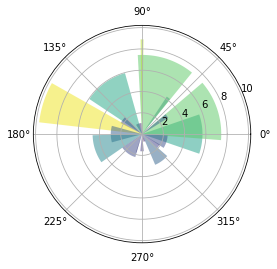

In [7]:
import numpy as np
import matplotlib.pyplot as plt
 
 
# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
 
ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)
 
# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r / 10.))
    bar.set_alpha(0.5)
 
plt.show()

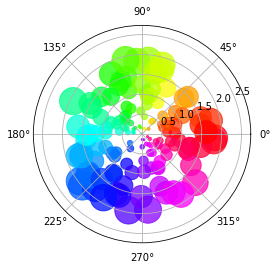

In [8]:
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 200 * r**2
colors = theta
 
ax = plt.subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)
 
plt.show()

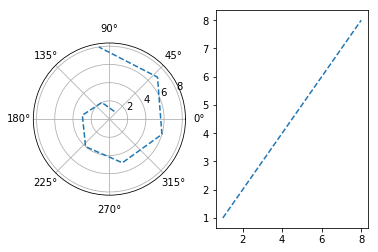

In [17]:
import matplotlib.pyplot as plt

# step1：准备画图的数据
theta = [1, 2, 3, 4, 5, 6, 7]  # 

# step2：手动创建一个figure对象，相当于一个空白的画布
fig = plt.figure()
# step3：在画布上添加2个子块，标定绘图位置
ax1 = fig.add_subplot(1, 2, 1, projection='polar')  # 指定绘制极坐标图
ax2 = fig.add_subplot(1, 2, 2)
# step4: 绘图
ax1.plot(theta, theta, '--')
ax2.plot(theta, theta, '--')

# 展示
plt.show()


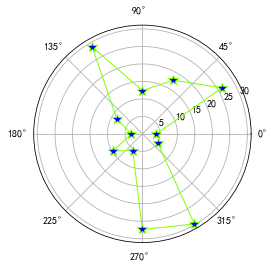

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# 防止乱码
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

barSlices = 12

theta = np.linspace(0.0, 2*np.pi, barSlices, endpoint=False)

r = 30*np.random.rand(barSlices)

plt.polar(theta,r,
          color = "chartreuse",
          linewidth = 1,
          marker = "*",
          mfc = "b",
          ms = 10)

plt.show()

In [33]:
# acos() 返回x的反余弦弧度值。
import math
x = 1
math.acos(x)

0.0

In [2]:
import torch
import math

# 求一个向量的模
input = torch.tensor([[1.,4.],[2.,4.],[3.,4.]])
mean_ = torch.norm(input,p=2)
mean_ = [mean_]*3
print(mean_)
torch.mean(torch.tensor(mean_))


[tensor(7.8740), tensor(7.8740), tensor(7.8740)]


tensor(7.8740)

In [38]:
torch.tensor([[1,4],[2,4],[3,4]]).float()

tensor([[1., 4.],
        [2., 4.],
        [3., 4.]])

In [3]:
# 求一个向量的模
input = torch.tensor([[1.],[1.],[1.]])
mean_ = torch.norm(input,p=2)
mean_ = [mean_]*3
print(mean_)
torch.mean(torch.tensor(mean_))

[tensor(1.7321), tensor(1.7321), tensor(1.7321)]


tensor(1.7321)

In [4]:
for i in range(3):
    print(i)
print(i)

0
1
2
2


In [9]:
torch.dot(torch.tensor([1.,1.,1.]), torch.tensor([2.,1.,2.]))

tensor(5.)

In [14]:
torch.mean(torch.tensor([1.,2.,3.]))

tensor(2.)